In [2]:
import numpy as np
import pandas as pd
from sklearn.svm import SVC, SVR
from sklearn.metrics import accuracy_score

## Load data

In [3]:
x_train = np.load("x_train.npy")
y_train = np.load("y_train.npy")
x_test = np.load("x_test.npy")
# y_test = np.load("y_test.npy")

In [4]:
# 7000 data with 300 features
print(x_train.shape)

(7000, 300)


In [5]:
# It's a binary classification problem 
print(np.unique(y_train))

[0 1]


## Question 1
K-fold data partition: Implement the K-fold cross-validation function. Your function should take K as an argument and return a list of lists (len(list) should equal to K), which contains K elements. Each element is a list contains two parts, the first part contains the index of all training folds, e.g. Fold 2 to Fold 5 in split 1. The second part contains the index of validation fold, e.g. Fold 1 in  split 1

In [6]:
rng = np.random.default_rng()
def cross_validation(x_train: np.ndarray, y_train: np.ndarray, k=5):
    fold_size = x_train.shape[0] // k
    remainder = x_train.shape[0] % k

    X = np.arange(x_train.shape[0])
    rng.shuffle(X)

    folds: list[np.ndarray] = []
    ind = 0
    for i in range(k):
        if i < remainder:
            folds.append(X[ind: ind + fold_size + 1])
            ind += fold_size + 1
        else:
            folds.append(X[ind: ind + fold_size])
            ind += fold_size

    kf: list[list[np.ndarray]] = []
    for i in range(k):
        train_index = folds[:i] + folds[i + 1:]
        train_index = np.concatenate(train_index)
        val_index = folds[i]
        kf.append([train_index, val_index])

    return kf

kfold_data = cross_validation(x_train, y_train, k=10)

In [7]:
kfold_data = cross_validation(x_train, y_train, k=10)
assert len(kfold_data) == 10 # should contain 10 fold of data
assert len(kfold_data[0]) == 2 # each element should contain train fold and validation fold
assert kfold_data[0][1].shape[0] == 700 # The number of data in each validation fold should equal to training data divieded by K

## example

In [8]:
from sklearn.model_selection import KFold

X = np.arange(20)
kf = KFold(n_splits=5, shuffle=True)
kfold_data= []
for i, (train_index, val_index) in enumerate(kf.split(X), start=1):
    print("Split: %s, Training index: %s, Validation index: %s" % (i, train_index, val_index))
    kfold_data.append([train_index, val_index])

Split: 1, Training index: [ 0  1  2  3  4  5  6  7  8  9 10 11 13 14 16 18], Validation index: [12 15 17 19]
Split: 2, Training index: [ 0  1  5  6  7  8  9 10 11 12 14 15 16 17 18 19], Validation index: [ 2  3  4 13]
Split: 3, Training index: [ 0  1  2  3  4  6  7  8 10 11 12 13 15 16 17 19], Validation index: [ 5  9 14 18]
Split: 4, Training index: [ 1  2  3  4  5  7  8  9 11 12 13 14 15 17 18 19], Validation index: [ 0  6 10 16]
Split: 5, Training index: [ 0  2  3  4  5  6  9 10 12 13 14 15 16 17 18 19], Validation index: [ 1  7  8 11]


In [9]:
assert len(kfold_data) == 5 # should contain 5 fold of data
assert len(kfold_data[0]) == 2 # each element should contains index of training fold and validation fold
assert kfold_data[0][1].shape[0] == 4 # The number of data in each validation fold should equal to training data divieded by K

## Question 2
Using sklearn.svm.SVC to train a classifier on the provided train set and conduct the grid search of “C” and “gamma” to find the best parameters by cross-validation.

In [10]:
clf = SVC(C=1.0, kernel='rbf', gamma=0.01)

In [11]:
## your code
C = [1e0, 1e1, 1e2, 1e3, 1e4]
gamma = [1e-4, 5e-4, 1e-5, 5e-5, 1e-4]
K = 5

# from tqdm import tqdm


max_acc = 0.0
best_parameters: tuple[float, float] = (0.0, 0.0)
acc_list: list[list] = []

# bar = tqdm(total=(len(C) * len(gamma) * K))

for c in C:
    acc_sub_list = []
    for g in gamma:
        total_acc = 0.0
        kfold_data = cross_validation(x_train=x_train, y_train=y_train)

        for folds in kfold_data:
            clf = SVC(C=c, kernel='rbf', gamma=g)
            x = x_train[folds[0]]
            y = y_train[folds[0]]
            clf.fit(x, y)
            
            x_val = x_train[folds[1]]
            y_val = y_train[folds[1]]
            y_pred = clf.predict(x_val)
            acc = accuracy_score(y_val, y_pred)
            total_acc += acc
            # bar.update(1)

        total_acc /= K
        acc_sub_list.append(total_acc)
        if total_acc > max_acc:
            max_acc = total_acc
            best_parameters = (c, g)

    acc_list.append(acc_sub_list)

# bar.close()
        

In [20]:
print(f"C: {best_parameters[0]}, gamma: {best_parameters[1]}")

C: 1000.0, gamma: 0.0001


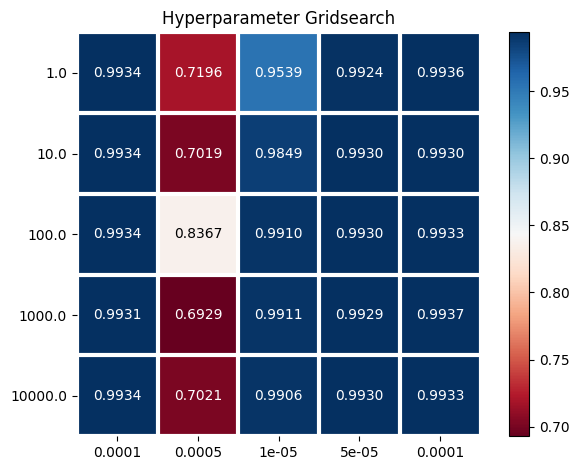

In [28]:
import matplotlib.pyplot as plt
from matplotlib.axes import Axes
from matplotlib.image import AxesImage
from matplotlib.ticker import StrMethodFormatter


def heatmap(
    data: np.ndarray,
    ax: Axes,
    row_labels,
    col_labels,
    cbar_kw=None,
    cbarlabel="",
    **kwargs
):
    """
    Create a heatmap from a numpy array and two lists of labels.

    Parameters
    ----------
    data
        A 2D numpy array of shape (M, N).
    row_labels
        A list or array of length M with the labels for the rows.
    col_labels
        A list or array of length N with the labels for the columns.
    ax
        A `matplotlib.axes.Axes` instance to which the heatmap is plotted.  If
        not provided, use current axes or create a new one.  Optional.
    cbar_kw
        A dictionary with arguments to `matplotlib.Figure.colorbar`.  Optional.
    cbarlabel
        The label for the colorbar.  Optional.
    **kwargs
        All other arguments are forwarded to `imshow`.
    """

    if cbar_kw is None:
        cbar_kw = {}

    # Plot the heatmap
    im = ax.imshow(data, **kwargs)

    # Create colorbar
    cbar = ax.figure.colorbar(im, ax=ax, **cbar_kw)
    cbar.ax.set_ylabel(cbarlabel, rotation=-90, va="bottom")

    # Show all ticks and label them with the respective list entries.
    ax.set_xticks(np.arange(data.shape[1]), labels=col_labels)
    ax.set_yticks(np.arange(data.shape[0]), labels=row_labels)

    # # Turn spines off and create white grid.
    ax.spines[:].set_visible(False)

    plt.savefig("test_plot.png")

    ax.set_xticks((np.arange(data.shape[1] + 1) - 0.5), minor=True)
    ax.set_yticks((np.arange(data.shape[0] + 1) - 0.5), minor=True)
    ax.grid(which="minor", color="w", linestyle="-", linewidth=3)
    ax.tick_params(which="minor", bottom=False, left=False)

    plt.savefig("test_plot_comp.png")

    return im, cbar


def annotate_heatmap(
    im: AxesImage, valfmt="{x:.2f}", textcolors=("black", "white"), **textkw
):
    """
    A function to annotate a heatmap.

    Parameters
    ----------
    im
        The AxesImage to be labeled.
    data
        Data used to annotate.  If None, the image's data is used.  Optional.
    valfmt
        The format of the annotations inside the heatmap.  This should either
        use the string format method, e.g. "$ {x:.2f}", or be a
        `matplotlib.ticker.Formatter`.  Optional.
    textcolors
        A pair of colors.  The first is used for values below a threshold,
        the second for those above.  Optional.
    **kwargs
        All other arguments are forwarded to each call to `text` used to create
        the text labels.
    """

    data: np.ndarray = im.get_array()

    # Normalize the threshold to the images color range.

    threshold = im.norm(data.max()) / 2

    # Set default alignment to center, but allow it to be
    # overwritten by textkw.
    kw = dict(horizontalalignment="center", verticalalignment="center")
    kw.update(textkw)

    # Get the formatter in case a string is supplied
    if isinstance(valfmt, str):
        valfmt = StrMethodFormatter(valfmt)

    # Loop over the data and create a `Text` for each "pixel".
    # Change the text's color depending on the data.
    texts = []
    for i in range(data.shape[0]):
        for j in range(data.shape[1]):
            kw.update(color=textcolors[int(abs(im.norm(data[i, j]) - threshold) > 0.2)])
            text = im.axes.text(j, i, valfmt(data[i, j]), **kw)
            texts.append(text)

    return texts


fig, ax = plt.subplots()

im, cbar = heatmap(
    data=np.array(acc_list),
    ax=ax,
    row_labels=C,
    col_labels=gamma,
    cmap="RdBu",
    cbarlabel="",
)
texts = annotate_heatmap(im, valfmt="{x:.4f}")

plt.title("Hyperparameter Gridsearch")
plt.tight_layout()
plt.savefig("result")
plt.show()

## Question 3
Plot the grid search results of your SVM. The x, y represents the hyperparameters of “gamma” and “C”, respectively. And the color represents the average score of validation folds
You reults should be look like this reference image below ![image](https://miro.medium.com/max/1296/1*wGWTup9r4cVytB5MOnsjdQ.png) 

## Question 4
Train your SVM model by the best parameters you found from question 2 on the whole training set and evaluate the performance on the test set.

In [ ]:
best_model = SVC(C=best_parameters[0], kernel='rbf', gamma=best_parameters[1]) # type: ignore
best_model.fit(x_train, y_train)

y_pred = best_model.predict(x_test)
print("Accuracy score: ", accuracy_score(y_pred, y_test))